In [2]:
import torch

In [86]:
import torch.nn as nn
import sys

In [102]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
writer= SummaryWriter("runs/mnist2")

In [103]:
import matplotlib.pyplot as plt

In [104]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Hyper Parameter Configuration**

In [105]:
input_size= 784
hidden_size= 100
num_classes= 10
num_epochs= 2
batch_size= 100
learning_rate= 0.01

In [106]:
train_dataset= torchvision.datasets.MNIST(root= './data', train= True, 
                                         transform= transforms.ToTensor(), download= True)

In [107]:
test_dataset= torchvision.datasets.MNIST(root= './data', train= False, 
                                         transform= transforms.ToTensor())

In [108]:
train_loader= torch.utils.data.DataLoader(dataset= train_dataset, batch_size= batch_size,
                                          shuffle= True)

In [109]:
test_loader= torch.utils.data.DataLoader(dataset= test_dataset, batch_size= batch_size,
                                          shuffle= False)

In [110]:
examples = iter(train_loader)
example_data, example_targets= next(examples)

In [111]:
for samples, labels in train_loader:
    break
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


100 Samples in the Batch <br>
1 Channel in the image as it is not colored one <br>
28 X 28 actual image array

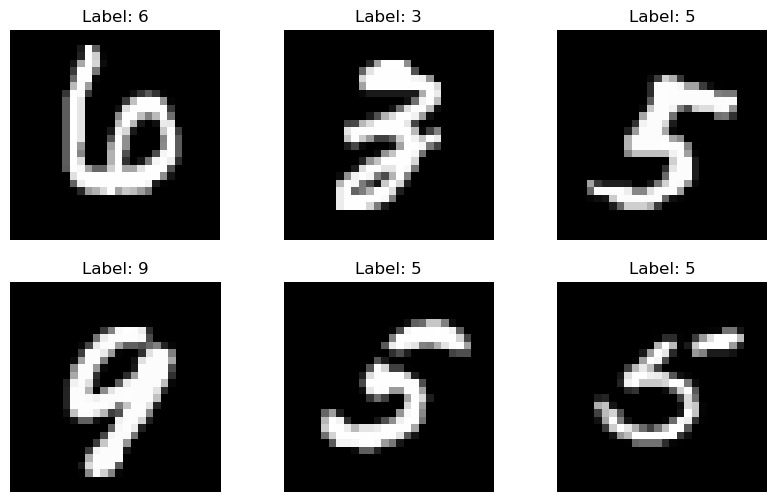

In [112]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))  

for i, ax in enumerate(axes.flatten()):  # Flatten axes to iterate over them easily
    ax.imshow(samples[i][0], cmap='gray') 
    ax.set_title(f'Label: {labels[i].item()}')  
    ax.axis('off')  

img_grid= torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images',img_grid)
writer.close()
#sys.exit()
#print(ax)
# plt.tight_layout()  
# plt.show()


**Neural Net Class** 

In [113]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1= nn.Linear(input_size, hidden_size)
        self.relu= nn.ReLU()
        self.l2= nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out= self.l1(x)
        #print(f'Self-L1= {out}')
        out= self.relu(out)
        #print(f'Self-relu= {out}')
        out= self.l2(out)
        #print(f'Self-L2= {out}')
        return out

In [114]:
model= NeuralNet(input_size, hidden_size, num_classes)
model.to(device)
print(model)
print(num_classes)

NeuralNet(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=10, bias=True)
)
10


**Loss and Optimizer**

In [115]:
criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)
writer.add_graph(model, example_data.reshape(-1, 28*28).to(device))
writer.close()
#sys.exit()
n_total_steps= len(train_loader)

In [116]:
running_loss= 0.0
running_correct = 0

**Training Loops**

In [117]:
n_total_steps= len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images= images.reshape(-1, 28*28).to(device)
        labels= labels.to(device)

        outputs= model(images)
        loss= criterion(outputs, labels)

        # Backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss+= loss.item()

        _, predicted= torch.max(outputs.data, 1)
        running_correct += (predicted== labels).sum().item()
        
        if (i+1)%100== 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            writer.add_scalar('training loss', running_loss/ 100, epoch*n_total_steps+i)
            writer.add_scalar('accuracy', running_correct/ 100, epoch*n_total_steps+i)
            running_loss= 0.0
            running_correct= 0

Epoch [1/2], Step [100/600], Loss: 0.2388
Epoch [1/2], Step [200/600], Loss: 0.2856
Epoch [1/2], Step [300/600], Loss: 0.1648
Epoch [1/2], Step [400/600], Loss: 0.1157
Epoch [1/2], Step [500/600], Loss: 0.0937
Epoch [1/2], Step [600/600], Loss: 0.1268
Epoch [2/2], Step [100/600], Loss: 0.1156
Epoch [2/2], Step [200/600], Loss: 0.1255
Epoch [2/2], Step [300/600], Loss: 0.1283
Epoch [2/2], Step [400/600], Loss: 0.0986
Epoch [2/2], Step [500/600], Loss: 0.2047
Epoch [2/2], Step [600/600], Loss: 0.1023


**Testing Loops**

In [118]:
with torch.no_grad():
    n_correct= 0
    n_samples= 0
    for images, labels in test_loader: 
        images= images.reshape(-1, 28*28).to(device)
        labels= labels.to(device)
        outputs= model(images)

        #Values and index,
        _, predictions= torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions== labels).sum().item()

    acc= 100.0* n_correct/ n_samples
    print(f'accuracy= {acc}')

accuracy= 96.76
